In [1]:
%matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plot_2D(matrix, title='FD matrix'):
    lim_margin = -0.05
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot()
    I, J = matrix.shape
    matrix_mag = np.log10(np.abs(matrix))
    ax.pcolor(matrix_mag[::-1])
    ax.set_xlim(-lim_margin, I+lim_margin)
    ax.set_ylim(-lim_margin, J+lim_margin)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', 'box')
    plt.title(title)
    plt.tight_layout()

Now let's try taking a derivative numerically. Say we have a function $f(x)$ which is periodic from $0$ to $2\pi$. We want to come up with a way to take a derivative of $f(x)$. Say we know the value of $f(x)$ on an evenly-spaced grid of points $x_i$.

In [3]:
N = 100
x = np.linspace(0, 2*np.pi, endpoint=False, num=N)

In [4]:
f = lambda x: np.cos(x)

In [5]:
f = np.cos(x)

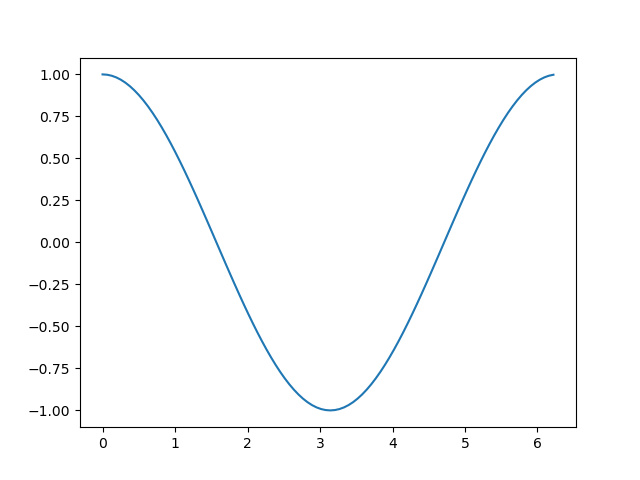

In [6]:
plt.figure()
plt.plot(x, f)

The derivative operator is a linear operator, so we wish to represent it as a matrix. The matrix is zero almost everywhere, so we will write it in terms of a sparse matrix.

In [7]:
import scipy.sparse as sparse

In [8]:
N = 100
h = x[1] - x[0]
shape = [N, N]
stencil = np.array([-1/(2*h), 0, 1/(2*h)])
offsets = [-1, 0, 1]
D = sparse.diags(stencil, offsets=offsets, shape=shape)

/var/folders/88/6pmmpt1j1yl6ry0001r5f_lr0000gn/T/ipykernel_6804/1292982914.py:9: RuntimeWarning: divide by zero encountered in log10
  matrix_mag = np.log10(np.abs(matrix))


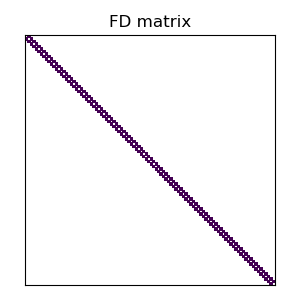

In [9]:
plot_2D(D.toarray())

In [10]:
D = D.tocsr()
D[0, -1] = -1/(2*h)
D[-1, 0] = 1/(2*h)

/Users/ericchen/opt/anaconda3/envs/446-1/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


/var/folders/88/6pmmpt1j1yl6ry0001r5f_lr0000gn/T/ipykernel_6804/1292982914.py:9: RuntimeWarning: divide by zero encountered in log10
  matrix_mag = np.log10(np.abs(matrix))


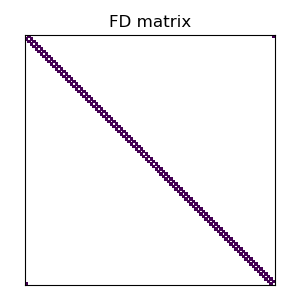

In [11]:
plot_2D(D.toarray())

In [12]:
D.toarray()[0]

array([ 0.        ,  7.95774715,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [13]:
df = D @ f(x)

TypeError: 'numpy.ndarray' object is not callable

NameError: name 'df' is not defined

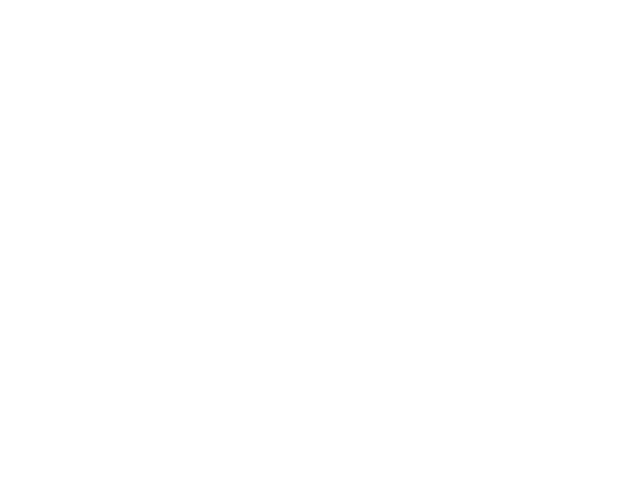

In [14]:
plt.figure()
plt.plot(x, df)
plt.plot(x, -np.sin(x))

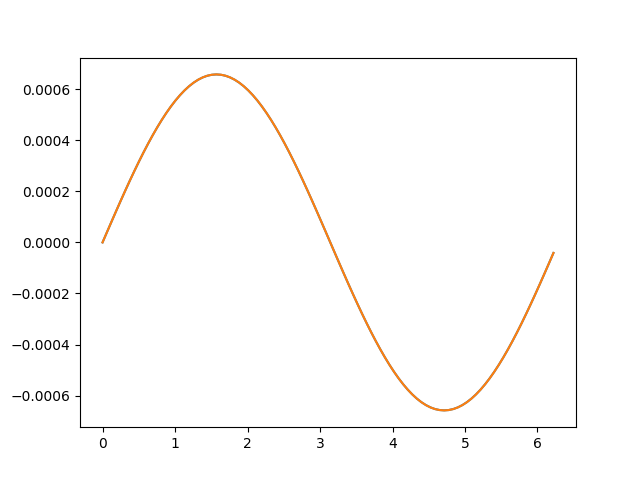

In [17]:
plt.figure()
plt.plot(x, df + np.sin(x))
plt.plot(x, np.sin(x)*h**2/6)

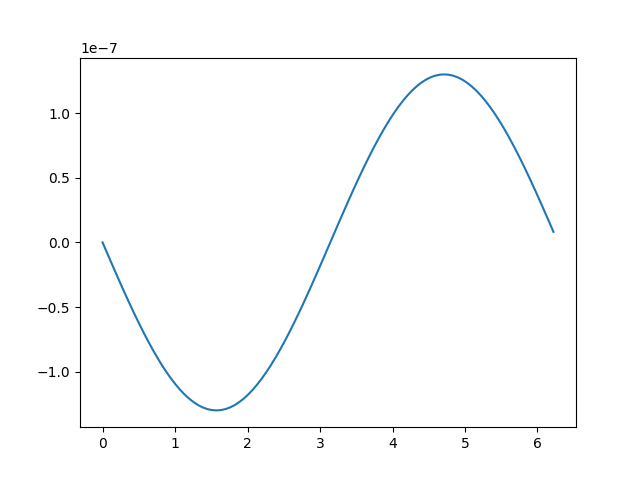

In [18]:
plt.figure()
plt.plot(x, df + np.sin(x) - np.sin(x)*h**2/6)

Next we want to test the convergence of the algorithm.

In [19]:
N_range = [50, 100, 200, 400]

errors = []
for N in N_range:
    x = np.linspace(0, 2*np.pi, endpoint=False, num=N)
    h = x[1] - x[0]
    shape = [N, N]
    stencil = np.array([-1/(2*h), 0, 1/(2*h)])
    offsets = [-1, 0, 1]
    D = sparse.diags(stencil, offsets=offsets, shape=shape)
    D = D.tocsr()
    D[0, -1] = -1/(2*h)
    D[-1, 0] = 1/(2*h)
    
    df = D @ f(x)
    
    error = np.max(np.abs(df + np.sin(x)))
    errors.append(error)
    
N_range = np.array(N_range)
errors = np.array(errors)

Text(0, 0.5, 'error')

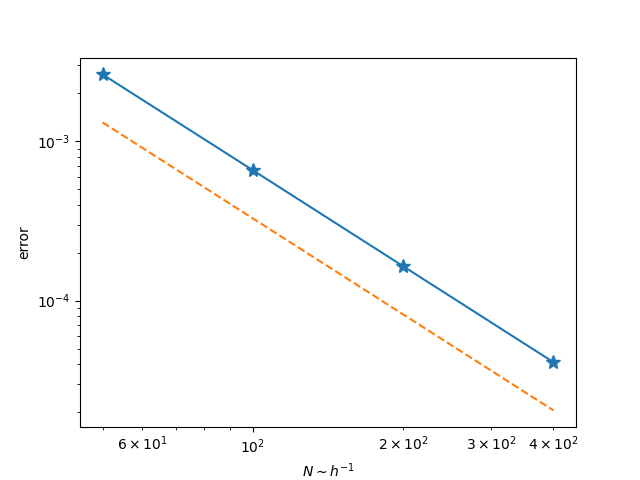

In [20]:
plt.figure()
plt.loglog(N_range, errors, marker='*', markersize=10)
plt.loglog(N_range, errors[0]/2*(N_range[0]/N_range)**2, linestyle='--')
plt.xlabel(r'$N\sim h^{-1}$')
plt.ylabel(r'error')

## Stencil
We will represent the derivative operation as
$$
D(f)_i = \sum_j f_{i+j} a_j
$$
We can expand each $f_{i+j}$ out in a power series
$$
f_{i+j} = \sum_{k=0}^{k_{max}} f_i^{(k)} \frac{1}{k!} (j h)^k
$$
Substituting in, we have
$$
D(f)_i = \sum_{j,k} f_i^{(k)} \frac{1}{k!} (j h)^k a_j
$$
We can think of this as a matrix of coefficients acting on the vector of $a_j$ and $f_i^{(k)}$
$$
D(f)_i = \mathbf{f} \cdot S \cdot \mathbf{a}
$$
where $\mathbf{f}$ is a row vector of the derivatives of $f_i$
$$
\mathbf{f} =
\begin{pmatrix}
f_i & f'_i & \cdots & f^{(k_{max})}_i
\end{pmatrix},
$$
$$
\mathbf{a} =
\begin{pmatrix}
a_{j_{min}} \\
a_{j_{min}+1} \\
\vdots \\
a_{j_{max}}
\end{pmatrix},
$$
$$
S_{k,j} = \frac{1}{k!} (j h)^k
$$

If we want to calculate the $k_0$ derivative to order $n$, then we need
$$
S\cdot \mathbf{a} = b
$$
where $b$ is a vector of zeros with length $k_0+n$, but with a one at the $k_0+1$ entry. In general, the term multiplying $f^{(k_0+n)}_i$ will be non-zero (though there may be accidental cancellation!). This will produce an error of size $h^n$, satisfying our requirement that the error is order $n$.

In [21]:
h = 1/100
S = np.array([[ 1, 1, 1],
              [-h, 0, h],
              [h**2/2, 0, h**2/2]])

In [22]:
b = np.array([0, 1, 0])

In [23]:
np.linalg.inv(S) @ b

array([-50.,   0.,  50.])

In [24]:
h = 1/100
S = np.array([[ 1, 1, 1],
              [-h, 0, h],
              [h**2/2, 0, h**2/2]])
b = np.array([0, 0, 1])

In [25]:
np.linalg.inv(S) @ b * h**2

array([ 1., -2.,  1.])